# Imports

In [1]:
from pyiron_contrib.tinybase.project import ProjectAdapter, InMemoryProject

/home/poul/pyiron/contrib/pyiron_contrib/__init__.py:9: UserWarning: pyiron module not found, importing Project from pyiron_base
  warnings.warn("pyiron module not found, importing Project from pyiron_base")


In [2]:
from ase.calculators.morse import MorsePotential

In [3]:
import logging
logging.getLogger().setLevel(20)

# Create Project and a new Job


In [4]:
pr = ProjectAdapter.open_location('tinyjob')

## MD Job

In [11]:
j = pr.create.job.AseMD('md')

In [17]:
j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2).to_ase()
j.input.calculator = MorsePotential()

In [18]:
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20

In [19]:
j.run()

In [9]:
j.output.animate_structures()

NGLWidget(max_frame=21)

## Min Job

In [10]:
j = pr.create.job.AseMinimize('min')

In [11]:
j.input.structure = pr.create.structure.atoms(
    symbols=['Fe', 'Fe'], 
    positions=[[0,0,0], [0,0, .75]], 
    cell=[10,10,10]
).to_ase()
j.input.structure.rattle(1e-3)
j.input.calculator = MorsePotential()

In [12]:
j.input.lbfgs(damping=.25)
j.input.ionic_force_tolerance = 1e-3
j.input.max_steps = 100
j.input.output_steps = 10

In [13]:
exe = j.run(
    executor=pr.create.executor.process(4)
)
if exe is not None:
    exe.wait()

INFO:root:Job already finished!


In [14]:
j.project.database.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,4,pyiron,md,1,1,8,/home/poul/pyiron/contrib/notebooks/tinybase/t...,finished,AseMDTask
1,5,pyiron,min,3,1,9,/home/poul/pyiron/contrib/notebooks/tinybase/t...,finished,AseMinimizeTask
2,6,pyiron,murn,2,1,11,/home/poul/pyiron/contrib/notebooks/tinybase/t...,finished,MurnaghanTask


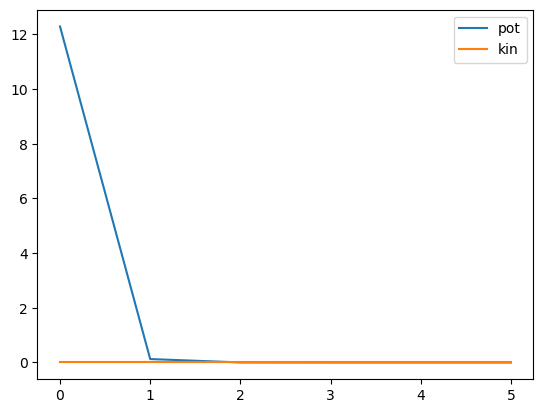

In [15]:
j.output.plot_energies()

In [16]:
j.output.animate_structures()

NGLWidget(max_frame=5)

### Loading from job id or name works

In [17]:
j.output.pot_energies

[11.28814567708869,
 -0.8747049787590951,
 -0.9988764739052705,
 -0.9999959367316252,
 -0.9999999870081488,
 -0.999999995888409]

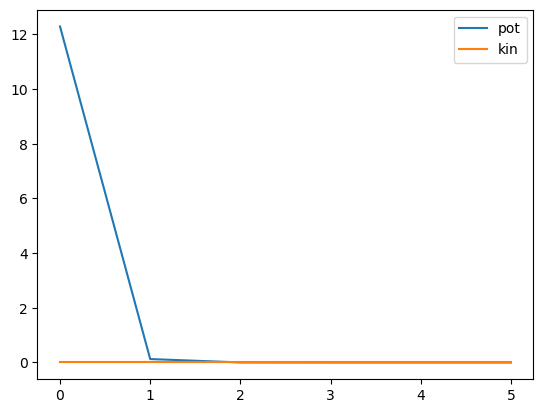

In [18]:
j.project.load(j.id).output.plot_energies()

In [19]:
j.project.load(j.name).output.animate_structures()

NGLWidget(max_frame=5)

## Murnaghan

In [20]:
murn = pr.create.job.Murnaghan('murn')

In [21]:
murn.input.task = pr.create.task.AseStatic()
murn.input.task.input.calculator = MorsePotential()

In [22]:
murn.input.structure = pr.create.structure.bulk("Fe", a=1.2).to_ase()

In [23]:
murn.input.set_strain_range(.5, 1000)

In [24]:
%%time
exe = murn.run(
    executor=pr.create.executor.process(4)
)
if exe is not None:
    exe.wait()

INFO:root:Job already finished!


CPU times: user 1.5 ms, sys: 727 µs, total: 2.23 ms
Wall time: 2.08 ms


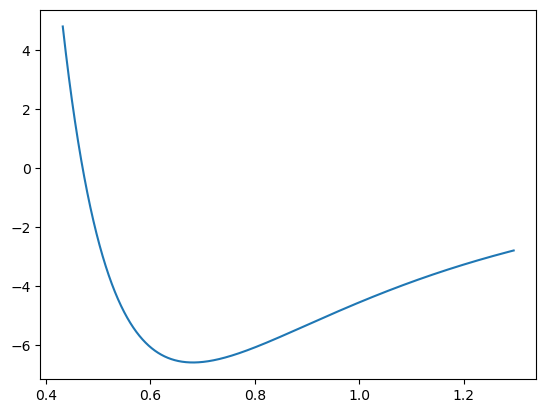

In [25]:
murn.output.plot()

# Pyiron purely in memory

Because the new ProjectInterface completely controls both the storage class and the database a job sees, we can easily swap them without changing anything in `TinyJob` at all.  As a demonstration we can make here a project that persists only for the duration of the process life time.  But it's not hard to imagine a number  of different project type depending on database configuration or storage location (S3, a single HDF5 for all jobs, etc.)

In [26]:
pr = InMemoryProject('/')

In [27]:
pr.job_table()

""


In [28]:
pr.exists_storage('murn')

False

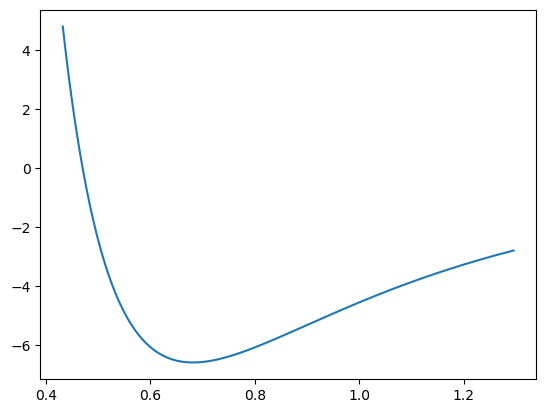

In [29]:
murn = pr.create.job.Murnaghan("murn")
murn.input.task = pr.create.task.AseStatic()
murn.input.task.input.calculator = MorsePotential()
murn.input.structure = pr.create.structure.bulk("Fe", a=1.2).to_ase()
murn.input.set_strain_range(.5, 500)
exe = murn.run(executor='process')
if exe is not None:
    exe.wait()
murn.output.plot()

In [30]:
pr.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,murn,1,1,1,/,finished,MurnaghanTask


In [31]:
j = pr.create.job.AseMD('md')
j.input.structure = pr.create.structure.bulk('Fe', a=1.2, cubic=True).repeat(2).to_ase()
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20
j.run(executor='background')

DEBUG:pyiron_log:Not supported parameter used!


In [32]:
pr.job_table()

,id,username,name,jobtype_id,project_id,status_id,location,status,type
0,1,pyiron,murn,1,1,1,/,finished,MurnaghanTask
1,2,pyiron,md,2,1,2,/,running,AseMDTask


Subprojects work.

In [33]:
sub = pr.open_location("/foo")
j = sub.create.job.AseMD('md')
j.input.structure = bulk('Fe', a=1.2, cubic=True).repeat(2)
j.input.calculator = MorsePotential()
j.input.steps = 100
j.input.timestep = 3.0
j.input.temperature = 600.0
j.input.output_steps = 20
j.run(how='process')

NameError: name 'bulk' is not defined

In [ ]:
pr.job_table()

# Database Tests

In [ ]:
db = j.project.database

In [ ]:
db.get_item(1)

In [ ]:
eng = db.engine

In [ ]:
from sqlalchemy.orm import Session

In [ ]:
s = Session(eng)

In [ ]:
from pyiron_contrib.tinybase.database import Job, Project as DProject, JobStatus, JobType

In [ ]:
s.query(Job.id).where(Job.name == "min", ).all()

In [ ]:
s.query(JobStatus.__table__).select_from(Job).where(Job.id == 2, Job.status_id == JobStatus.id).all()

In [ ]:
s.query(JobStatus.__table__).all()

In [ ]:
s.query(DProject.__table__).all()

In [ ]:
s.query(JobType.__table__).all()